(90000, 6720) (6720,)


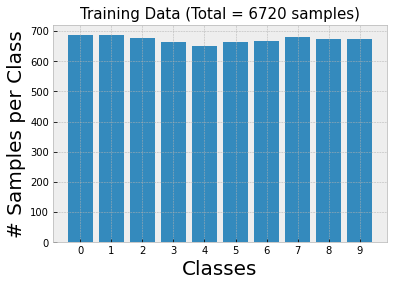

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('new_labels_train.npy')

print(data_train.shape, labels_train.shape)

# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

# Displaying some examples per class

# for i in range(0,10):
#     rnd_sample = npr.permutation(np.where(labels_train==i)[0])
#     fig=plt.figure(figsize=(15,15))
#     for j in range(25):
#         fig.add_subplot(5,5,j+1)
#         plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300)),cmap='gray')
#         plt.axis('off');plt.title('Class '+str(int(labels_train[rnd_sample[j]])),size=15)
#     plt.show()
#     print('\n\n')

import pandas as pd
X = pd.DataFrame(data_train.T)


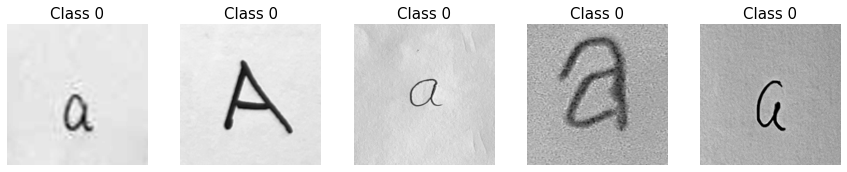

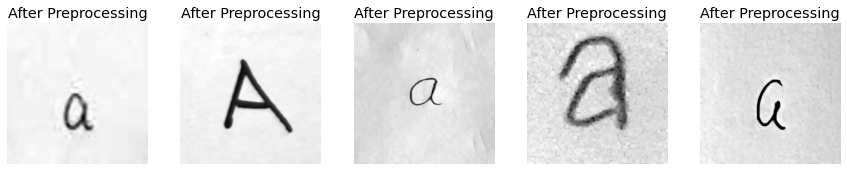

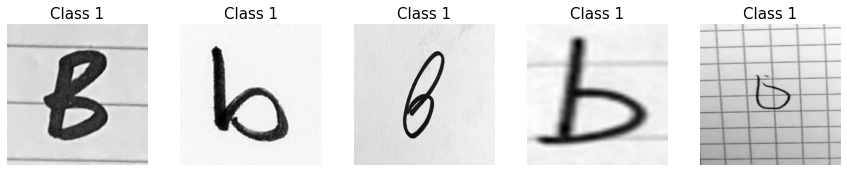

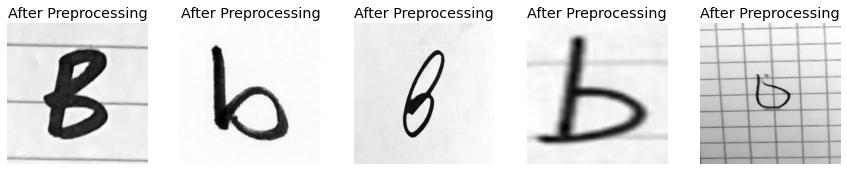

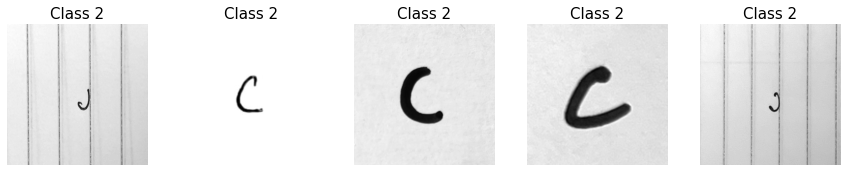

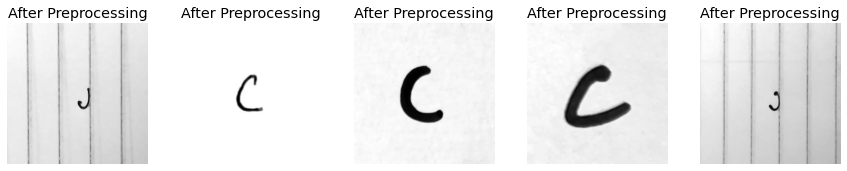

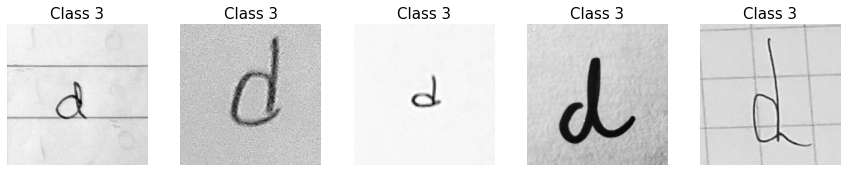

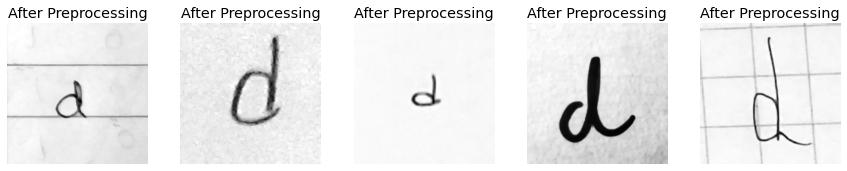

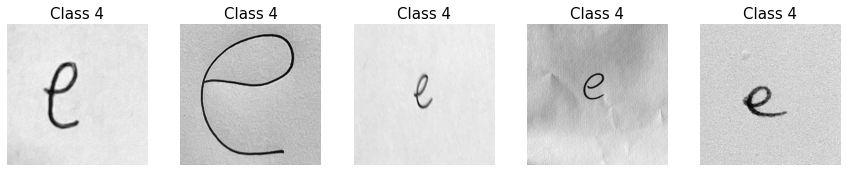

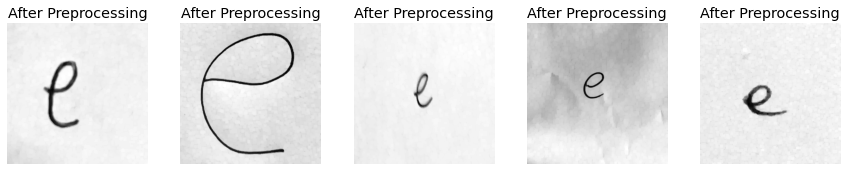

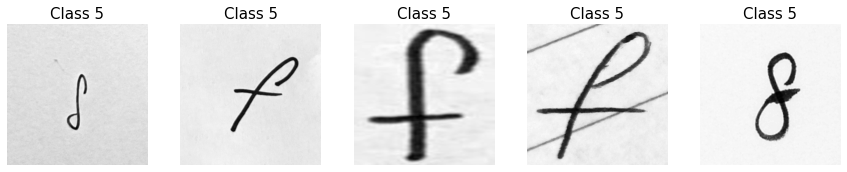

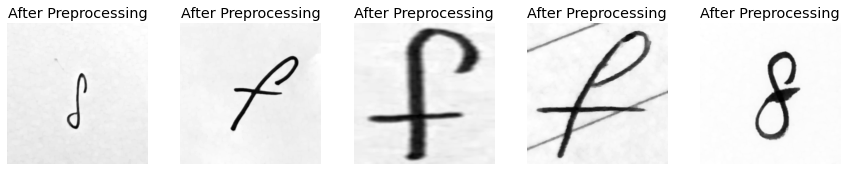

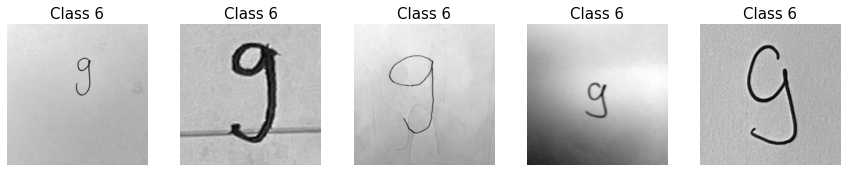

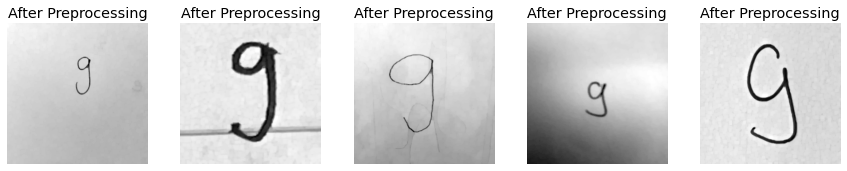

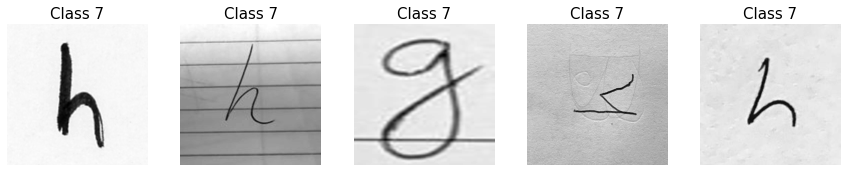

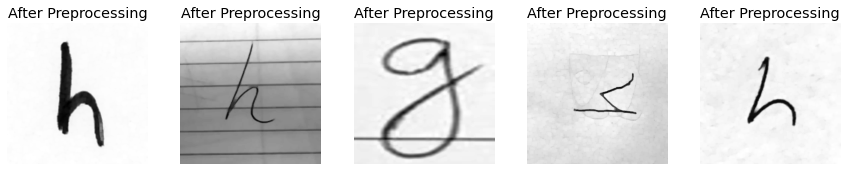

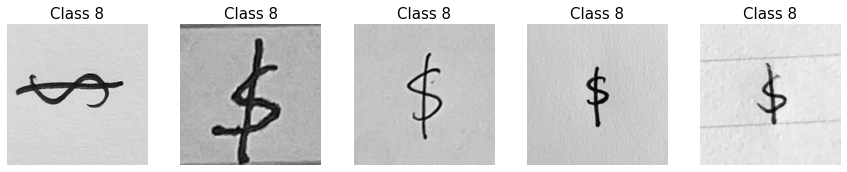

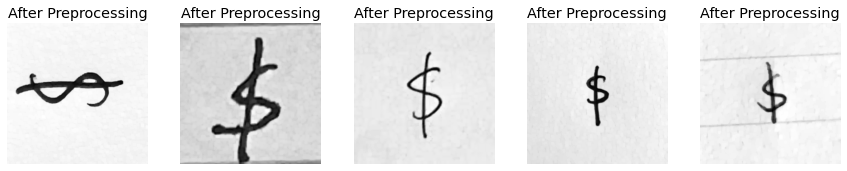

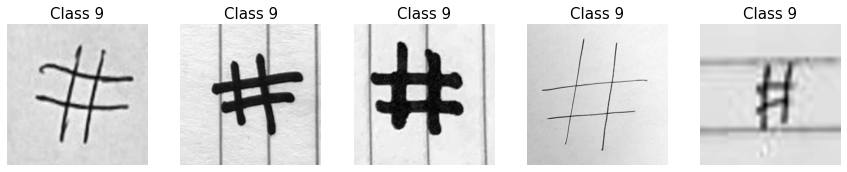

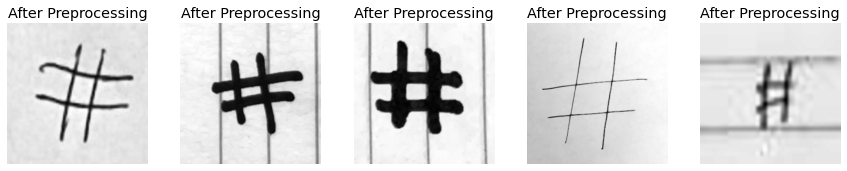

In [19]:
import cv2
kernel = np.ones((5,5),np.uint8)
for i in range(0,10):
    rnd_sample = npr.permutation(np.where(labels_train==i)[0])
    fig1=plt.figure(figsize=(15,15))
    for j in range(5):
        fig1.add_subplot(5,5,j+1)
        plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300)),cmap='gray')
#         plt.imshow(cv2.medianBlur((data_train[:,rnd_sample[j]].reshape((300,300))), 3))
        plt.axis('off');plt.title('Class '+str(int(labels_train[rnd_sample[j]])),size=15)
    plt.show()
    print('\n\n')
    j = 0
    fig=plt.figure(figsize=(15,15))
    dt = []
    k=0
    for j in range(5):
        fig.add_subplot(5,5,j+1)
#         plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300)),cmap='gray')
        dt.append(cv2.medianBlur((data_train[:,rnd_sample[j]].reshape((300,300))), 3))
        dt[j] = cv2.morphologyEx(dt[j], cv2.MORPH_OPEN, kernel)
        plt.imshow(dt[j],cmap='gray')
        k = k + 1
        plt.axis('off');plt.title('After Preprocessing')
    plt.show()
    print('\n\n')

(6720, 50, 50)
(6048, 50, 50, 1) (6048, 10) (672, 50, 50, 1) (672, 10)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_6 (RandomCon (None, 50, 50, 1)         0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 46, 46, 32)        832       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 42, 42, 32)        25632     
_________________________________________________________________
batch_normalization_18 (Batc (None, 42, 42, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________

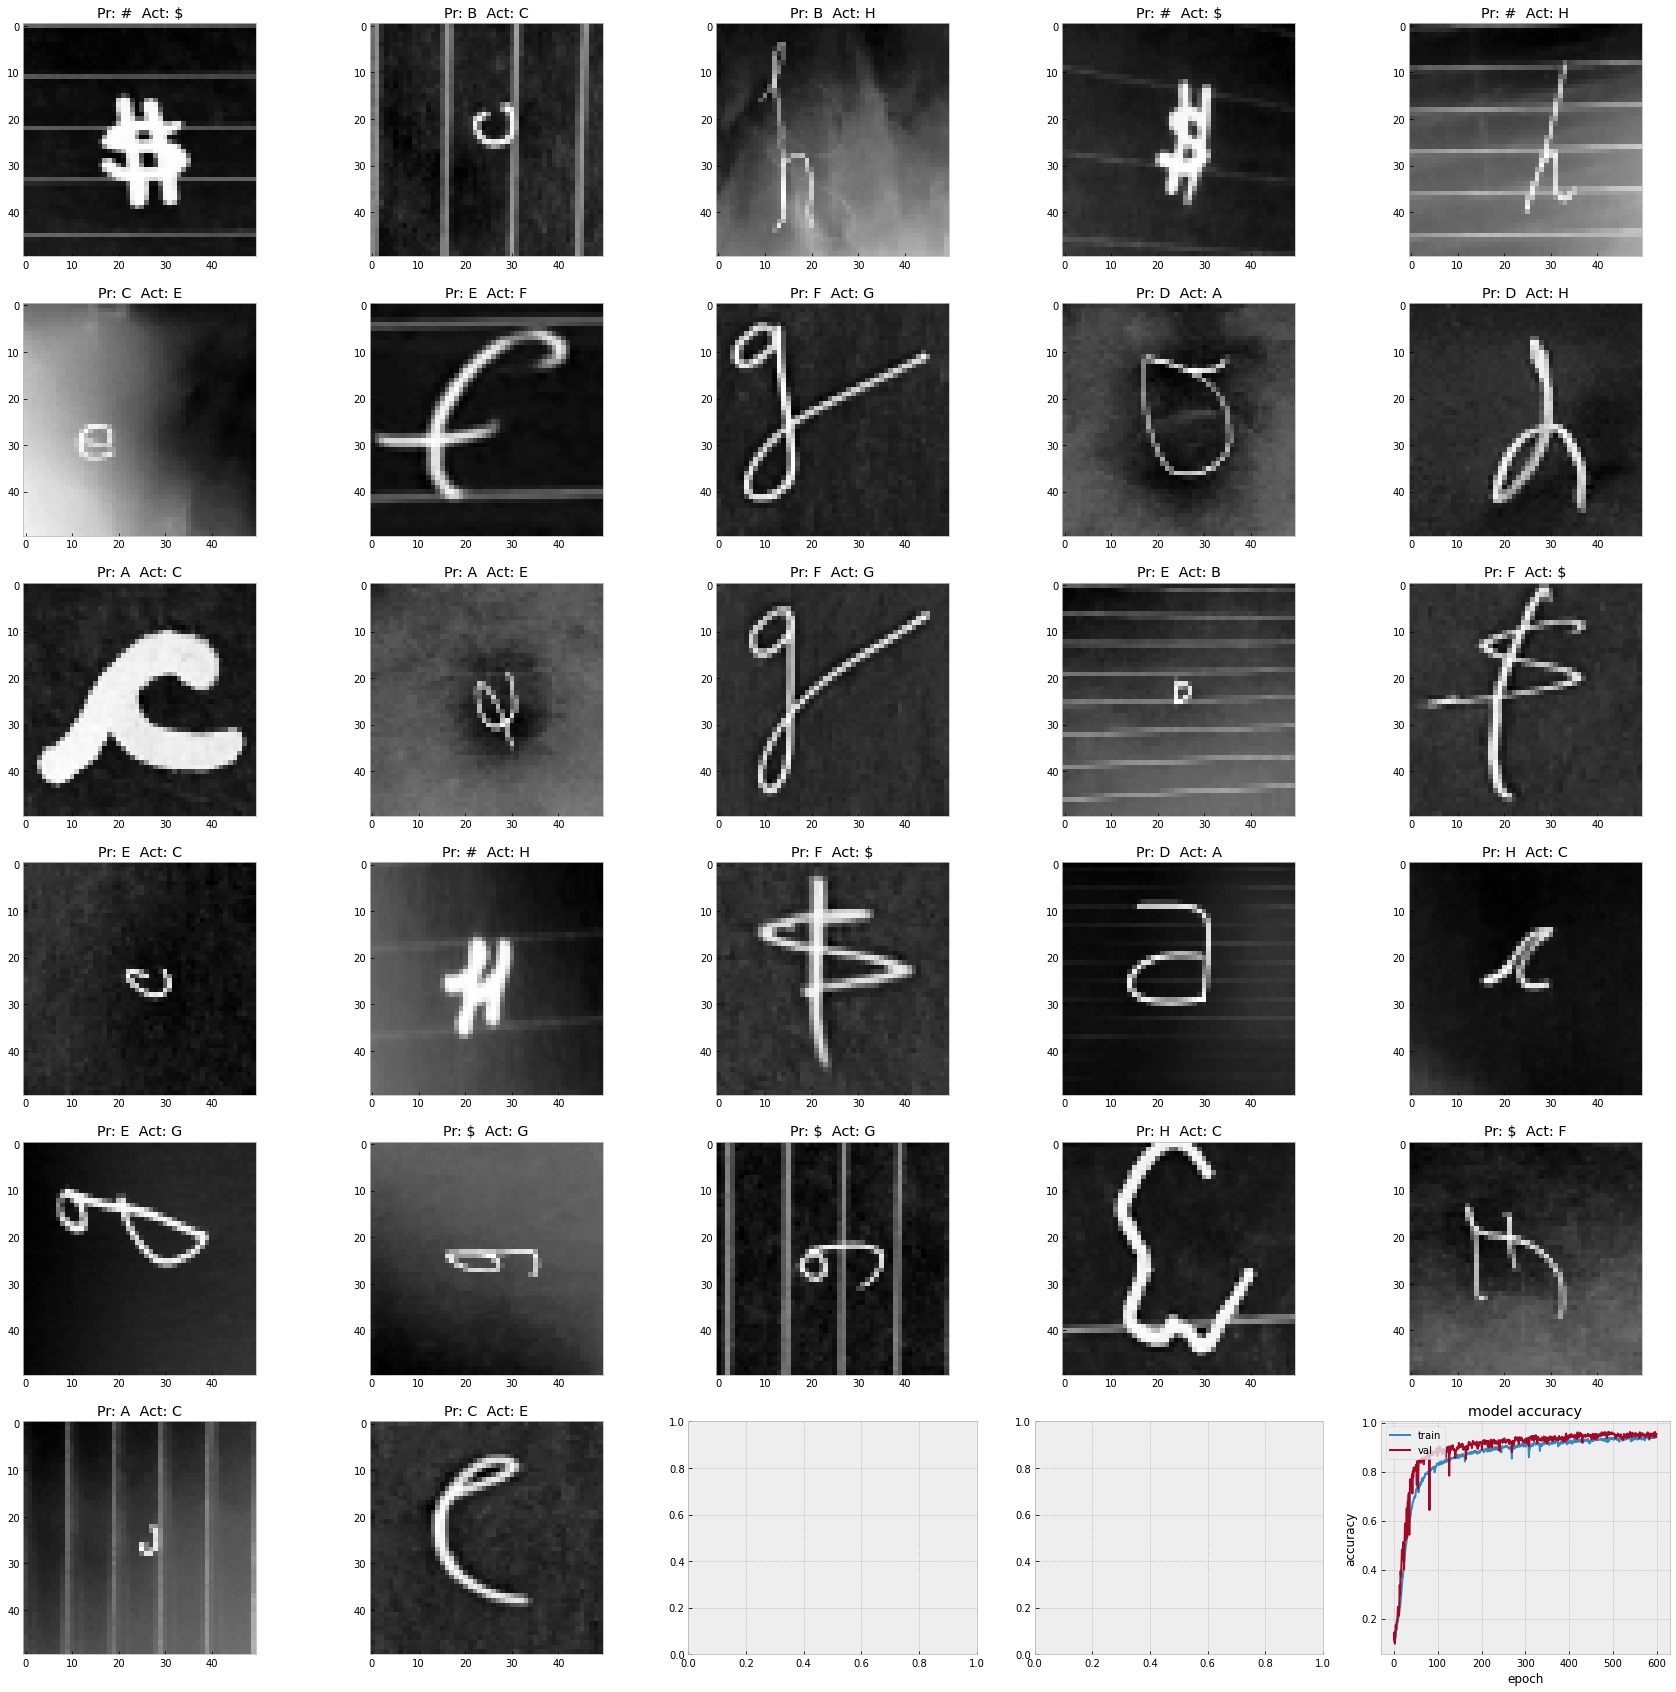

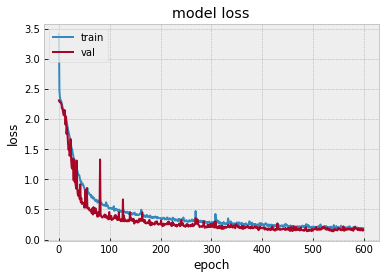

In [20]:
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'$',9:'#'}
import argparse
import skimage as sk
from skimage import transform
from skimage import util
import cv2
# load train and test dataset
def load_dataset():
    # load dataset
    data_rgb = []
    kernel = np.ones((4,4),np.uint8)
    for i in range(6720):
        data_rgb.append(data_train[:,i].reshape(300,300))
        data_rgb[i] = cv2.medianBlur(data_rgb[i], 3)
        data_rgb[i] = cv2.morphologyEx(data_rgb[i], cv2.MORPH_OPEN, kernel)
        data_rgb[i] = cv2.resize(data_rgb[i], (50,50), interpolation=cv2.INTER_AREA)
    data_rgb = np.array(data_rgb)
    print(data_rgb.shape)
    trainX, testX, trainY, testY = train_test_split(data_rgb, labels_train, test_size = 0.1, stratify=labels_train)
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 50,50, 1))
    testX = testX.reshape((testX.shape[0], 50,50, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# he_uniformize to range 0-1
	train_norm = (train_norm) / 255.0
	test_norm = (test_norm) / 255.0
	# return he_uniformized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
    model = Sequential()
    model.add(RandomContrast((0,0.3),input_shape=(50,50,1)))
    model.add(RandomRotation(0.1, fill_mode='reflect', interpolation='bilinear'))
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(50,50, 1)))
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3,3),activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3,3),activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
#     model.add(Dense(30000, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = Adam(learning_rate=0.0007 , epsilon=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, tes_X, tes_y):
    model = define_model()
    print("Model Defined", model.summary())
    # select rows for train and test
    trainX, trainY, testX, testY = dataX, dataY, tes_X, tes_y
    # fit model
    history = model.fit(trainX, trainY, epochs = 600, batch_size=32, validation_split = 0.1, verbose=1)
    print("Model Fitted")
    # evaluate model
    _, acc = model.evaluate(tes_X, tes_y, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    pred = model.predict(tes_X)
    wr = []
    index = []
    te = []
    te = np.array(tes_y)
    print(te.shape)
    for b in range(672):
        wr.append(np.argmax(pred[b]))
        if wr[b] != np.argmax(te[b]):
            index.append(b)
    wr= np.array(wr)
    index = np.array(index)
    print(index, index.shape)
    fig, axes = plt.subplots((len(index)//5)+1,5, figsize=(30,30))
    axes = axes.flatten()
    h = 0
    for i,ax in enumerate(axes):
        if h == len(index):
            break
        img = np.reshape(tes_X[index[h]], (50,50))
        cr = np.argmax(te[index[h]])
        ax.imshow(img, cmap="Greys")
        pred = word_dict[wr[index[h]]]
        h = h + 1
        ax.set_title("Pr: "+pred+"  Act: "+word_dict[cr])
        ax.grid()
    print("\n\n")
    return model, history
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()
 
# run the test harness for evaluating a model
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    model, history = evaluate_model(trainX, trainY, testX, testY)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return model
# entry point, run the test harness
model = run_test_harness()

In [21]:
model.save("Final_CNN")

2022-04-12 15:57:46.998716: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Final_CNN/assets
